**AUTORES:**

**Juliana García Quintero**

**Jhara Castañez Martinez**

**Alexis Yulian Puetate Paspuel**

**PROYECTO IV**

**PROCESAMIENTO DE IMAGENES POR TRANSFORMADORES**

**INTRODUCCIÓN:**

Este cuaderno realiza un análisis completo de imágenes contenidas en un archivo ZIP para apoyar la inspección de infraestructura eléctrica. Utiliza técnicas de visión artificial y machine learning para identificar componentes y evaluar su estado.

Funciones principales:

Detección de aisladores, líneas eléctricas y vegetación cercana.

Procesamiento previo de imágenes (grises, bordes, segmentación).

Clasificación del estado general mediante un modelo Random Forest.

Generación de métricas, visualizaciones y diagnóstico final.

**LIBRERIAS IMPORTADAS:**
Algunas de las librerias que usamos ya las conociamos pero estas son las que utilizamos nuevas:


```
# from scipy import ndimage
```
Proporciona un conjunto de funciones para el procesamiento de imágenes y datos multidimensionales, como filtrado, transformaciones, convoluciones y operaciones morfológicas.


```
# from sklearn.cluster import KMeans
```
Incluye la implementación del algoritmo clustering K-Means, nos permite agrupar datos según su similitud.


```
# from sklearn.metrics import confusion_matrix
```
Sirve para evaluar modelos de clasificación, comparando las predicciones del modelo con las reales, en pocas palabras calcula la matriz de confusión para evaluar el rendimiento.



```
# import sys
```
Permite acceder a variables internas del intérprete de Python y gestionar aspectos del sistema.






In [ ]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import os
import sys


**LECTURA DEL DATASET .ZIP IMAGENES TERMICAS DE TRASNFORMADORES Y AISLADORES.**

Imágenes encontradas en el ZIP: 114
Ingresa el número de la imagen a analizar (1 - 114): 99


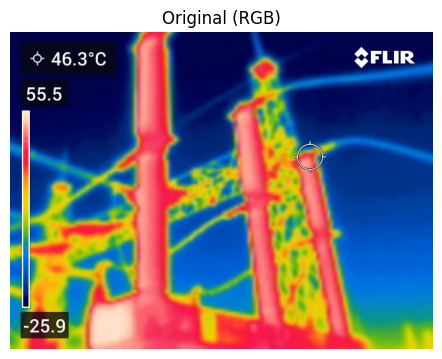

In [ ]:
zip_path = "ProyectoIV.zip"

# Abrir ZIP y listar JPG
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"No se encontró el archivo: {zip_path}")

with zipfile.ZipFile(zip_path, "r") as z:
    image_files = [f for f in z.namelist() if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    image_files.sort()

if len(image_files) == 0:
    raise RuntimeError("No se encontraron imágenes JPG/PNG dentro del ZIP.")

total = len(image_files)
print(f"Imágenes encontradas en el ZIP: {total}")

# Selección segura de imagen (si se ejecuta en entorno interactivo)
try:
    n = int(input(f"Ingresa el número de la imagen a analizar (1 - {total}): "))
except Exception:
    n = 1
n = max(1, min(total, n))
selected_image = image_files[n - 1]

# Leer imagen desde ZIP

with zipfile.ZipFile(zip_path, "r") as z:
    img_bytes = z.read(selected_image)

img_array = np.frombuffer(img_bytes, np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
if img is None:
    raise RuntimeError("cv2.imdecode devolvió None (posible archivo corrupto o formato no soportado).")

# Mantengo copia original para visualización
img_rgb_orig = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualización inicial
plt.figure(figsize=(12,5))
plt.subplot(1,2,1);
plt.imshow(img_rgb_orig);
plt.title("Original (RGB)");
plt.axis("off");


**PREPROCESAMIENTO:**

En esta sección se realiza el preprocesamiento básico de la imagen para mejorar su calidad y facilitar su posterior análisis. Se ajusta su tamaño, se convierte a escala de grises, se suaviza para reducir ruido y finalmente se detectan los bordes principales. Luego se muestran las distintas etapas del preprocesamiento para visualizar cómo va cambiando la imagen a medida que se aplican estos pasos.

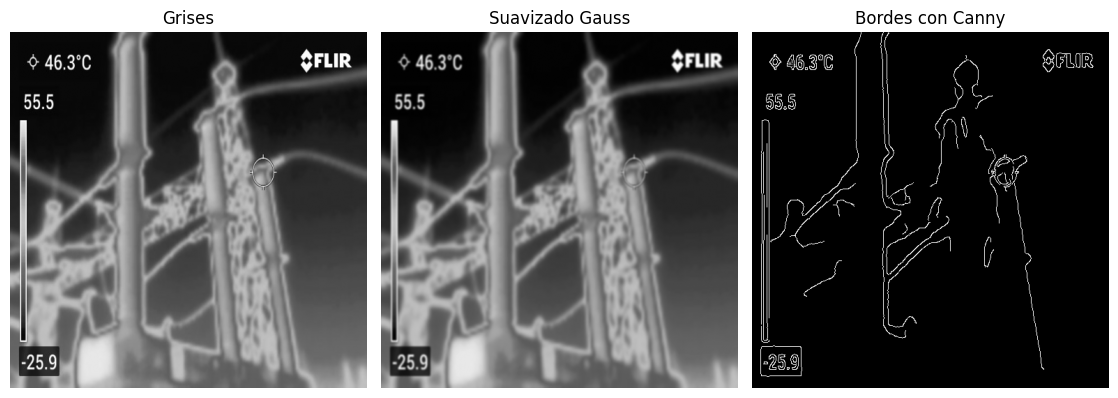

In [ ]:
# Preprocesamiento
IMG_SIZE = (512, 512)
img_resized = cv2.resize(img, IMG_SIZE)
img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
img_edges = cv2.Canny(img_blur, 50, 150)

# Visualización
plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.imshow(img_gray, cmap='gray')
plt.title("Grises")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_blur, cmap='gray')
plt.title("Suavizado Gauss")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(img_edges, cmap='gray')
plt.title("Bordes con Canny")
plt.axis("off")

plt.tight_layout()
plt.show()

**TABLA DE TEMPERATURAS:**

En esta sección se calculan estadísticas básicas de la imagen en escala de grises, que en este contexto representan valores de temperatura. Se obtiene la intensidad máxima, mínima y el promedio de los píxeles, interpretados como temperaturas. Según el valor promedio, se determina un nivel de riesgo que clasifica la condición térmica en categorías como bajo, medio, alto o crítico. Finalmente, estos resultados se organizan en una tabla para facilitar su visualización y análisis.

In [ ]:
#Tabla de temperatura
max_temp = int(img_gray.max())
min_temp = int(img_gray.min())
mean_temp = float(img_gray.mean())

# Intensidades de 0-255 temperaturas
if mean_temp < 60:
    riesgo = " - Bajo – Dentro de parámetros"
elif mean_temp < 110:
    riesgo = "- Medio – Calentamiento leve"
elif mean_temp < 160:
    riesgo = "- Alto – Sobrecalentamiento"
else:
    riesgo = "- Crítico – Temperaturas muy altas"

tabla_temperaturas = pd.DataFrame({
    "Parámetro": ["Intensidad Máx", "Intensidad Mín", "Promedio", "Nivel de Riesgo"],
    "Valor": [max_temp, min_temp, round(mean_temp, 2), riesgo]})
print("TABLA DE TEMPERATURAS")
print(tabla_temperaturas.to_string(index=False))


TABLA DE TEMPERATURAS
      Parámetro                        Valor
 Intensidad Máx                          255
 Intensidad Mín                            2
       Promedio                        92.41
Nivel de Riesgo - Medio – Calentamiento leve


**TABLA DE FALLAS:**

En esta sección se realiza un análisis detallado de las posibles fallas térmicas presentes en la imagen. Se definen distintos rangos de intensidad que corresponden a diferentes niveles de condición térmica, desde aire o normal hasta sobrecalentamiento extremo. Para cada rango, se calcula la cantidad de píxeles que caen dentro del intervalo y el porcentaje que representan respecto al total de la imagen. Los resultados se organizan en una tabla que muestra la falla detectada, el rango de intensidad, el número de píxeles afectados y su porcentaje relativo, facilitando así la evaluación visual y cuantitativa del estado térmico.

In [ ]:
#TABLA DE FALLAS
rangos = {
    "Aire": (0, 50),
    "Normal": (51, 120),
    "Calentamiento moderado": (121, 180),
    "Calentamiento crítico": (181, 230),
    "Sobrecalentamiento extremo": (231, 255),
}
res = {"Falla Detectada": [], "Rango de intensidad": [], "Píxeles": [], "Porcentaje (%)": []}
total_pixeles = img_gray.size

for falla, (low, high) in rangos.items():
    mask = (img_gray >= low) & (img_gray <= high)
    conteo = int(mask.sum())
    porcentaje = (conteo / total_pixeles) * 100
    res["Falla Detectada"].append(falla)
    res["Rango de intensidad"].append(f"{low}{high}")
    res["Píxeles"].append(conteo)
    res["Porcentaje (%)"].append(round(porcentaje, 2))

tabla_fallas = pd.DataFrame(res)
tabla_fallas["Porcentaje (%)"] = tabla_fallas["Porcentaje (%)"].apply(lambda x: f"{x}%")

print("TABLA DE FALLAS Y PORCENTAJES")
print(tabla_fallas.to_string(index=False))

TABLA DE FALLAS Y PORCENTAJES
           Falla Detectada Rango de intensidad  Píxeles Porcentaje (%)
                      Aire                 050    85732          32.7%
                    Normal               51120    85173         32.49%
    Calentamiento moderado              121180    72545         27.67%
     Calentamiento crítico              181230    15809          6.03%
Sobrecalentamiento extremo              231255     2885           1.1%


**DETECCIÓN DE PUNTOS CALIENTES:**

En esta sección se identifican las zonas con temperaturas elevadas en la imagen, llamadas puntos calientes, a partir de un umbral definido. Se cuenta cuántos puntos calientes hay y qué porcentaje del área total representan, para evaluar visualmente y cuantitativamente las posibles zonas de riesgo térmico.

In [ ]:
#Detección de puntos calientes
UMBRAL_CALIENTE= 180
mascara_caliente_simple= img_gray >= UMBRAL_CALIENTE
labeled, puntos_calientes = ndimage.label(mascara_caliente_simple)
Area_caliente_pixeles= int(mascara_caliente_simple.sum())
Area_caliente_porcentaje= (Area_caliente_pixeles/ total_pixeles) * 100

print("ANÁLISIS DE PUNTOS CALIENTES")
print(f"Puntos calientes detectados: {puntos_calientes}")
print(f"Área total caliente por pixeles: {Area_caliente_pixeles}")
print(f"Área caliente (%): {Area_caliente_porcentaje:.2f}%")

ANÁLISIS DE PUNTOS CALIENTES
Puntos calientes detectados: 152
Área total caliente por pixeles: 19943
Área caliente (%): 7.61%


**DETECCIÓN DE VEGETACIÓN:**

En esta sección se realiza la detección de vegetación cercana en la imagen. Se identifican las áreas verdes utilizando un rango de color específico y se aplican operaciones morfológicas para limpiar la máscara resultante. Posteriormente, se detectan y marcan las zonas de vegetación más relevantes con contornos y rectángulos, mostrando su área aproximada. Finalmente, se visualizan las áreas detectadas, facilitando la evaluación de la vegetación presente cerca de la infraestructura.

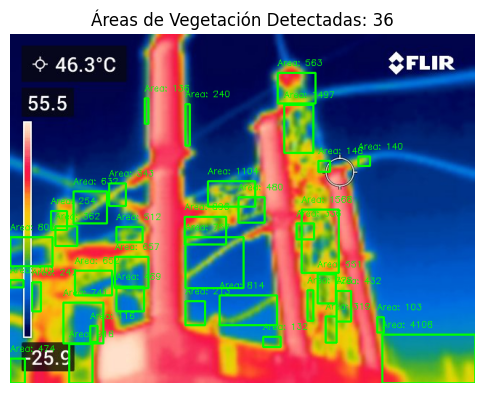

In [ ]:
#Detección de vegetación
def detectar_vegetacion_cercana(imagen_color):
    """Detección de vegetación cerca de infraestructura"""
    hsv = cv2.cvtColor(imagen_color, cv2.COLOR_RGB2HSV)

    # Rangos de vegetación
    lower_green = np.array([35, 50, 50])
    upper_green = np.array([85, 255, 255])

    mask_vegetacion = cv2.inRange(hsv, lower_green, upper_green)
    kernel = np.ones((5,5), np.uint8)
    mask_vegetacion = cv2.morphologyEx(mask_vegetacion, cv2.MORPH_CLOSE, kernel)
    mask_vegetacion = cv2.morphologyEx(mask_vegetacion, cv2.MORPH_OPEN, kernel)

    # Encontrar contornos de vegetación
    contornos, _ = cv2.findContours(mask_vegetacion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_con_vegetacion = imagen_color.copy()
    areas_vegetacion = []

    for contorno in contornos:
        area = cv2.contourArea(contorno)
        if area > 100:
            areas_vegetacion.append(area)
            x, y, w, h = cv2.boundingRect(contorno)
            cv2.rectangle(img_con_vegetacion, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(img_con_vegetacion, f"Area: {int(area)}", (x, y-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)
    return img_con_vegetacion, areas_vegetacion, mask_vegetacion

img_vegetacion, areas_veg, _ = detectar_vegetacion_cercana(img_rgb_orig)

#Visualización
plt.figure(figsize=(6, 6))
plt.imshow(img_vegetacion)
plt.title(f"Áreas de Vegetación Detectadas: {len(areas_veg)}")
plt.axis('off')
plt.show()

**DETECCIÓN DE OBJETOS:**

En esta sección se realiza la detección de los principales objetos presentes en la infraestructura eléctrica. Se identifican aisladores, líneas eléctricas y vegetación cercana, evaluando su cantidad y estado. Los resultados se resumen en una tabla que indica cuántos elementos fueron detectados y si requieren revisión, mantenimiento o poda, facilitando un análisis rápido del estado general de la instalación.

In [ ]:
#Detección de objetos

def detectar_aisladores(imagen_gray, imagen_color):
    """Detección de aisladores"""
    circles = cv2.HoughCircles(
        imagen_gray,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=50,
        param2=30,
        minRadius=8,
        maxRadius=25
    )
    img_con_detecciones = imagen_color.copy()
    aisladores_detectados = 0
    posiciones_aisladores = []

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        aisladores_detectados = len(circles)

        for (x, y, r) in circles:
            # Dibujar círculo alrededor del aislador
            cv2.circle(img_con_detecciones, (x, y), r, (0, 255, 0), 2)
            cv2.circle(img_con_detecciones, (x, y), 2, (0, 0, 255), 3)
            posiciones_aisladores.append((x, y, r))

            # Analizar región del aislador para detectar daños
            region = imagen_gray[
                max(0, y-r):min(imagen_gray.shape[0], y+r),
                max(0, x-r):min(imagen_gray.shape[1], x+r)
            ]

            if region.size > 0:
                intensidad_promedio = np.mean(region)
                varianza = np.var(region)

                # Clasificación simple
                if varianza > 1000:
                    estado = "POSIBLE FISURA"
                    color = (255, 0, 0)  # Rojo
                elif intensidad_promedio < 50:
                    estado = "ENSUCIADO"
                    color = (255, 165, 0)  # Naranja
                else:
                    estado = "NORMAL"
                    color = (0, 255, 0)  # Verde

                cv2.putText(
                    img_con_detecciones, estado, (x-40, y-30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1
                )

    return img_con_detecciones, aisladores_detectados, posiciones_aisladores

def detectar_lineas_electricas(imagen_edges, imagen_color):
    """Detección de líneas eléctricas usando Hough Lines"""
    lines = cv2.HoughLinesP(
        imagen_edges, 1, np.pi/180, threshold=50,
        minLineLength=50, maxLineGap=10
    )

    img_con_lineas = imagen_color.copy()
    lineas_detectadas = 0

    if lines is not None:
        lineas_detectadas = len(lines)
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img_con_lineas, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return img_con_lineas, lineas_detectadas

# Aplicar detección de objetos
img_aisladores, num_aisladores, posiciones_aisladores = detectar_aisladores(img_gray, img_rgb_orig)
img_lineas, num_lineas = detectar_lineas_electricas(img_edges, img_rgb_orig)
img_vegetacion, areas_veg, _ = detectar_vegetacion_cercana(img_rgb_orig)

#Tabla
tabla_deteccion_objetos = [
    ["Componente", "Cantidad Detectada", "Estado"],
    ["Aisladores", num_aisladores, "OK" if num_aisladores > 2 else "Revisar"],
    ["Líneas Eléctricas", num_lineas, "OK" if num_lineas > 0 else "No detectadas"],
    ["Vegetación Cercana", len(areas_veg), "Poda necesaria" if len(areas_veg) > 2 else "Aceptable"]
]

# Mostrar tabla en consola de forma legible
print("TABLA DE DETECCIÓN DE OBJETOS")
for fila in tabla_deteccion_objetos:
    print("{:<20} {:<20} {:<20}".format(*fila))


TABLA DE DETECCIÓN DE OBJETOS
Componente           Cantidad Detectada   Estado              
Aisladores           5                    OK                  
Líneas Eléctricas    25                   OK                  
Vegetación Cercana   36                   Poda necesaria      


**MODELO DE DIAGNOSTICO:**

En esta sección se realiza un diagnóstico automático de la imagen utilizando el algoritmo de K-Means para agrupar los píxeles según su intensidad. Esto permite identificar zonas frías, medias y calientes en la infraestructura. A partir de estos clusters se calcula el porcentaje de píxeles en cada categoría y se asocia una interpretación sobre el estado del componente, indicando posibles problemas como sobrecalentamiento, funcionamiento normal o presencia de humedad o fugas térmicas. Los resultados se presentan en una tabla que resume las zonas, su porcentaje y su descripción.

In [ ]:
# DIAGNÓSTICO K-MEANS
img_flat = img_blur.reshape((-1,1)).astype(np.float32)
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans.fit(img_flat)
labels_1d = kmeans.labels_
labels = labels_1d.reshape(img_gray.shape)

# Cálculo de medias con manejo de clusters vacíos
cluster_means = []
counts = []
for i in range(3):
    mask = (labels == i)
    cnt = int(mask.sum())
    counts.append(cnt)
    if cnt == 0:
        cluster_means.append(-1.0)
    else:
        cluster_means.append(float(img_gray[mask].mean()))

if all(m == -1.0 for m in cluster_means):
    raise RuntimeError("Todos los clusters quedaron vacíos (imposible).")

#Identificación de cluster caliente y frío
hot_cluster = int(np.nanargmax(np.array(cluster_means)))
cold_cluster = int(np.nanargmin(np.array([m if m>=0 else 1e9 for m in cluster_means])))

hot_pixels = int((labels == hot_cluster).sum())
cold_pixels = int((labels == cold_cluster).sum())
mid_pixels = total_pixeles - hot_pixels - cold_pixels

hot_percent = (hot_pixels / total_pixeles) * 100
cold_percent = (cold_pixels / total_pixeles) * 100
mid_percent = (mid_pixels / total_pixeles) * 100

# Datos para el diagnóstico
categorias = ["Zona fría", "Zona media", "Zona caliente"]
porcentajes = [round(cold_percent, 2), round(mid_percent, 2), round(hot_percent, 2)]
descripciones = [
    "Puede indicar humedad, mala aislación o fuga térmica",
    "Funcionamiento normal / carga estable",
    "Sobrecalentamiento localizado o posible falla interna"
]

# IMPRESIÓN DEL DIAGNÓSTICO

print("TABLA DE DIAGNÓSTICO AUTOMÁTICO K-MEANS")

for cat, pct, desc in zip(categorias, porcentajes, descripciones):
    print(f"Categoría   {cat}")
    print(f"Porcentaje   {pct}%")
    print(f"Descripción   {desc}")
    print("-" * 5)

TABLA DE DIAGNÓSTICO AUTOMÁTICO K-MEANS
Categoría   Zona fría
Porcentaje   36.2%
Descripción   Puede indicar humedad, mala aislación o fuga térmica
-----
Categoría   Zona media
Porcentaje   33.53%
Descripción   Funcionamiento normal / carga estable
-----
Categoría   Zona caliente
Porcentaje   30.27%
Descripción   Sobrecalentamiento localizado o posible falla interna
-----


**EVALUACIÓN DEL MODELO:**

En esta sección se evalúa el rendimiento del modelo de segmentación térmica utilizando K-Means. Primero, se asignan etiquetas reales a los píxeles según rangos de temperatura (frío, medio y caliente) y se compara con las etiquetas predichas por el modelo mediante una matriz de confusión. A partir de esta matriz se calcula la precisión general y se realiza un análisis detallado por clase, mostrando qué porcentaje de zonas frías, medias y calientes fueron correctamente detectadas. Finalmente, se emite una interpretación del rendimiento, destacando si el modelo funciona bien o si presenta dificultades, especialmente en la detección de puntos calientes, que son críticos para identificar posibles fallas térmicas.

In [ ]:
# EVALUACIÓN DEL MODELO

# Convertimos a etiquetas térmicas reales según rangos
true_labels = np.zeros_like(img_blur) # Changed from img_gray to img_blur for consistent dimensions

true_labels[(img_blur >= 0) & (img_blur <= 120)] = 0   # frío
true_labels[(img_blur > 120) & (img_blur <= 180)] = 1  # medio
true_labels[(img_blur > 180)] = 2                      # caliente

# Matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels.flatten(), labels.flatten())

print("MATRIZ DE CONFUSIÓN")
print(cm)

# Precisión del modelo
accuracy = np.trace(cm) / np.sum(cm)
print("-"* 10)
print(f"Precisión aproximada del modelo: {accuracy*100:.2f}%")

# EVALUACIÓN DEL RENDIMIENTO
print("-"* 10)
print("EVALUACIÓN DEL RENDIMIENTO")

if accuracy >= 0.90:
    print("El modelo está funcionando EXCELENTE: Detecta muy bien las zonas frías, medias y calientes.")
elif 0.75 <= accuracy < 0.90:
    print("El modelo funciona BIEN pero puede mejorar: Algunas zonas están siendo mal clasificadas.")
else:
    print("El modelo está teniendo DIFICULTADES para clasificar la imagen.")
    print(" Puede estar confundiendo puntos calientes con zonas frías o medias.")

# Evaluación específica por clases
print("-"* 10)
print("ANÁLISIS DETALLADO POR CLASE")

total_frio     = cm[0].sum()
total_medio    = cm[1].sum()
total_caliente = cm[2].sum()

print(f"Frío correctamente detectado:     {cm[0,0]} de {total_frio}  ___ {cm[0,0]/total_frio*100:.2f}%")
print(f"Medio correctamente detectado:    {cm[1,1]} de {total_medio} ___ {cm[1,1]/total_medio*100:.2f}%")
print(f"Caliente correctamente detectado: {cm[2,2]} de {total_caliente} ___ {cm[2,2]/total_caliente*100:.2f}%")
print("-"* 10)
if cm[2,2] / total_caliente < 0.70:
    print("ALERTA IMPORTANTE: La detección de puntos calientes es baja.")
    print("Esto podría ocultar fallas térmicas críticas en el transformador.")
elif cm[2,2] / total_caliente < 0.90:
    print("Advertencia: La detección de puntos calientes es aceptable, pero mejorable.")
else:
    print("Excelente: Los puntos calientes se detectan de manera muy precisa.")

MATRIZ DE CONFUSIÓN
[[74534 94894     0]
 [13368     0 62919]
 [    0     0 16429]]
----------
Precisión aproximada del modelo: 34.70%
----------
EVALUACIÓN DEL RENDIMIENTO
El modelo está teniendo DIFICULTADES para clasificar la imagen.
 Puede estar confundiendo puntos calientes con zonas frías o medias.
----------
ANÁLISIS DETALLADO POR CLASE
Frío correctamente detectado:     74534 de 169428  ___ 43.99%
Medio correctamente detectado:    0 de 76287 ___ 0.00%
Caliente correctamente detectado: 16429 de 16429 ___ 100.00%
----------
Excelente: Los puntos calientes se detectan de manera muy precisa.


**DIAGNOSTICO:**

En esta sección se realiza el diagnóstico final del equipo a partir del análisis térmico y visual de la imagen. Se evalúan las zonas calientes, frías y medias para determinar si existen sobrecalentamiento, distribución térmica irregular o anomalías críticas.

Además, se realiza un diagnóstico específico por ensuciamiento, identificando posibles acumulaciones de suciedad en la superficie, y un diagnóstico de daño físico, analizando la irregularidad de los bordes para detectar posibles fisuras o deformaciones. Los resultados se presentan de manera resumida, proporcionando una interpretación clara del estado del equipo y posibles acciones a seguir.

In [ ]:
# Diagnóstico
diagnostico = ""
if hot_percent < 1 and cold_percent < 1:
    diagnostico = "El equipo parece comportarse Térmicamente bien."
elif hot_percent > 20:
    diagnostico = "Sobrecalentamiento severo: Revisar devanados / conexiones / carga."
elif 5 < hot_percent <= 20:
    diagnostico = "Sobrecalentamiento moderado: Revisar ventilación, aceite o conexiones."
elif cold_percent > 15:
    diagnostico = "Zona fría anormal: Posible fuga térmica, humedad o problema de aislación."
elif mid_percent < 40:
    diagnostico = "Distribución térmica irregular: Posible daño incipiente."
else:
    diagnostico = "No se observan anomalías críticas; seguir monitoreo."
print("DIAGNÓSTICO:")
print("-" *10)
print(diagnostico)

# Diagnóstico por ensuciamiento y daño físico

diagnostico_ensuciamiento = "No se observan signos fuertes de ensuciamiento."
if cold_percent > 15 and hot_percent < 3:
    diagnostico_ensuciamiento = "Posible ENSUCIAMIENTO EXTERNO severo."
elif 8 < cold_percent <= 15 and mid_percent > 50:
    diagnostico_ensuciamiento = "Ensuciamiento moderado."
elif cold_percent > 10 and hot_percent < 1:
    diagnostico_ensuciamiento = "Acumulación ligera de suciedad."

edge_intensity = float(np.mean(img_edges))
if edge_intensity > 40:
    diagnostico_dano = "Posible DAÑO FÍSICO: bordes muy irregulares."
elif edge_intensity < 10:
    diagnostico_dano = "No se detectan daños físicos visibles."
else:
    diagnostico_dano = "Patrón de bordes normal."
print("-"*10)
print("DIAGNÓSTICO POR ENSUCIAMIENTO:", diagnostico_ensuciamiento)
print("-"*10)
print("DIAGNÓSTICO DE DAÑO FÍSICO:", diagnostico_dano)

DIAGNÓSTICO:
----------
Sobrecalentamiento severo: Revisar devanados / conexiones / carga.
----------
DIAGNÓSTICO POR ENSUCIAMIENTO: No se observan signos fuertes de ensuciamiento.
----------
DIAGNÓSTICO DE DAÑO FÍSICO: No se detectan daños físicos visibles.


**HISTOGRAMA:**
En esta sección se genera un histograma de intensidades de la imagen en escala de grises, que sirve como un proxy de las temperaturas. El histograma permite visualizar la distribución de los valores de intensidad y observar la frecuencia de píxeles en distintos rangos, lo que ayuda a identificar zonas frías, medias y calientes de manera rápida y clara.

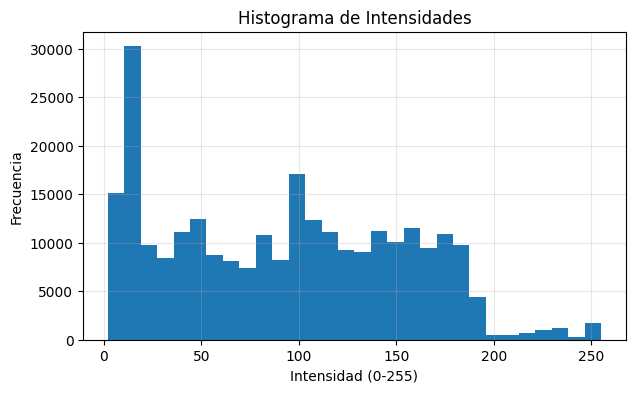

In [ ]:
# Histogramas y barras
plt.figure(figsize=(7,4))
plt.hist(img_gray.flatten(), bins=30)
plt.title("Histograma de Intensidades")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()


**CONCLUSIÓN:**

El análisis integró información térmica y visual para evaluar el estado de la infraestructura, identificar zonas críticas y proponer acciones preventivas. Las técnicas aplicadas permiten un monitoreo sistemático y automatizado, facilitando la detección temprana de problemas térmicos, daños físicos o ensuciamiento que podrían comprometer la operación segura del sistema eléctrico.